# Linear Discrimant Analysis and Support Vector Machines

Today we are going to explore two more Classification methods. 

It is worth pausing though and pointing out that we will not have time in this class to go over every method. It is worth reading through the documentation on the scikitlearn help page to see the complete lists of methods for which we have algorithms. The documentation includes a discussion of the mathematical underpinnings of the methods as well as some advice on what problems or types of issues they are meant to work best on.

[scikitlearn documentation](https://scikit-learn.org/stable/)

To review, for classification we have learned two quite different methods:

*Logistic Regression*: which aims at estimating the probability of a class by fitting a logistic function to it. These results in a linear decision boundary, and a model with only a few degrees of freedome (which can be adjusted by adding nonlinear transformations of the features).

*K-Nearest Neighbors*: which uses the classifications of the nearest neighbors to choose the value. In contrast to *Logistic Regression* this gives a model with a high degree of freedom, which can capture non-linear features of the data.

Today's methods are not necessarily meant to fix defeciciences in either of these methods but are meant more to fill in the space on the spectrum of flexibility versus overfitting.

## Linear Discriminant Analysis 

We actually saw this method in the first example from our first class, but did not give it a name there. The idea is, as with *Logistic Regression* to use the training data to estimate the probability that a given point is in a class, and then choose the class with the greater probability. The difference is that rather than fitting the logistic function to that probability, we will instead estimate the distribution of each class and then classify the points by which one is more likely.

Recall the problem of classifying whether a baseball player is a pitcher or not-a-pitcher based on their height or height-and-weight.

In [49]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco
import numpy.random as rn
import seaborn as sn

In [6]:
# Read in the major league players data set

major = pa.read_csv('Data Sets/Major League Height-Weight.csv')   # creates a pandas Dataframe from a .csv file
major = major.rename({'Height(inches)':'Height', 'Weight(pounds)':'Weight'}, axis=1)  
major = major.drop(640, axis=0) 

# Each row of a data frame is a data point - in this case a player.
# Each column is a feature about the data point (its coordinates if you will)

major.head()   # displays the first few rows

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


In [19]:
# We are going to make a dictionary of key:value pairs to recode the Position feature to 
# 'Pitcher' and 'Not Pitcher'

pos_dict = {x:1 for x in list(set(major.Position)) if 'Pitcher' in x}
pos_dict2 = {x:0 for x in list(set(major.Position)) if not 'Pitcher' in x}

# Using dictionary comprehensions

pos_dict.update(pos_dict2) # merge the two dictionaries

major_2 = major.copy()   # pandas.dataframe is a mutable object so we use the .copy() command 
                         # otherwise changes to major_2 will change major
    
major_2.Position = major_2.Position.map(pos_dict)  # use the dictionary we made to recode the values with .map()

major_2

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,0,74,180.0,22.99
1,Paul_Bako,BAL,0,74,215.0,34.69
2,Ramon_Hernandez,BAL,0,72,210.0,30.78
3,Kevin_Millar,BAL,0,72,210.0,35.43
4,Chris_Gomez,BAL,0,73,188.0,35.71
...,...,...,...,...,...,...
1029,Brad_Thompson,STL,1,73,190.0,25.08
1030,Tyler_Johnson,STL,1,74,180.0,25.73
1031,Chris_Narveson,STL,1,75,205.0,25.19
1032,Randy_Keisler,STL,1,75,190.0,31.01


Explicitly what we are trying to do is to compute the conditional probability from Bayes' rule:

$$ P(y=k | X) = \frac{P(X | y=k) P(y=k)}{P(X)} = 
\frac{P(X |y=k) P(y=k) }{ \sum P(X|y=l) P(y=l) } $$

Note that in the left had side the quantities $P(y=k)$ are just the proportions from the training data; and the quantities $P(X |y = k) $ are what we need estimates of.

*Linear Discriminant Analysis* is based on the assumption that these probabilities are given by a Gaussian Distribution:

$$ p_k(X) = P(X | y=k) = \frac{1}{N} \exp\left( -\frac{1}{2} (X - \mu_k)^t \Sigma_k (X - mu_k) \right) $$

where $\mu_k$ is the vector of means for the $y=k$ class, and $\Sigma_k$ is the covariance matrix. 

Of course the problem is an estimate, and so the algorithm determines, given the training data for class $y=k$ the values of $\mu_k$ and $\Sigma_k$ that give the best result. 

One simplificiation is that we will assume that the covariance matrices are the same for all classes. This means that the boundaries between classes will be given by linear expressions, hence *Linear Discriminant Analysis*

*Quadratic Deiscriminant Analysis* allows each $\Sigma_k$ to be independent and gives boundaries between classes given by quadratic expressions.

### One Dimensional Example

In one dimension (i.e. one predictor) the problem is straightforward. From the training data,  the mean of the predictor for each class and an estimate the variance from the full set of training data is computed.

In [20]:
X = np.atleast_2d(np.array(major_2['Height'])).transpose()
y = np.array(major_2['Position'])

In [21]:
mu_1 = X[y==1].mean()
mu_0 = X[y==0].mean()
mu_1, mu_0

(74.5214953271028, 72.81526104417671)

In [24]:
mu = X.mean()
sigma2 = ((X - mu)**2).mean()
sigma2

5.3140066105076516

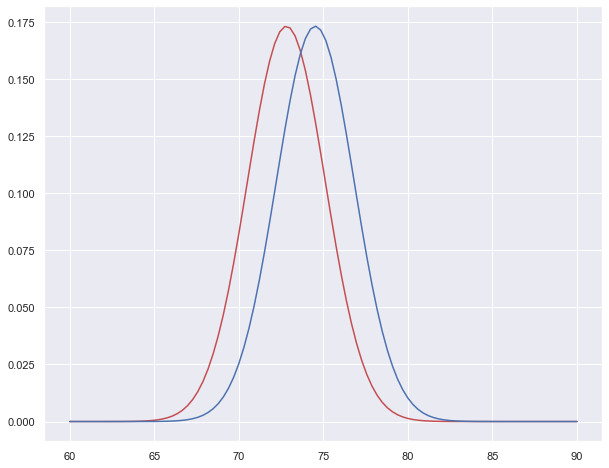

In [37]:
xx = np.linspace(60, 90, 100)
p0 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_0)**2/(2*sigma2))
p1 = 1/np.sqrt(2*np.pi*sigma2)*np.exp(-(xx-mu_1)**2/(2*sigma2))

plt.figure(figsize=(10, 8))
plt.plot(xx, p0, 'r-')
plt.plot(xx, p1, 'b-');

This picture is not exactly what we want, it is the $P(X | y=k)$ for $y=0$ and $y=1$. We now need to use the values of this function to compute the Bayes probability: $P(y=k | X)$ at each point, note that this then takes into account the relative frequencies of each of the classes via the $P(y=k)$. 

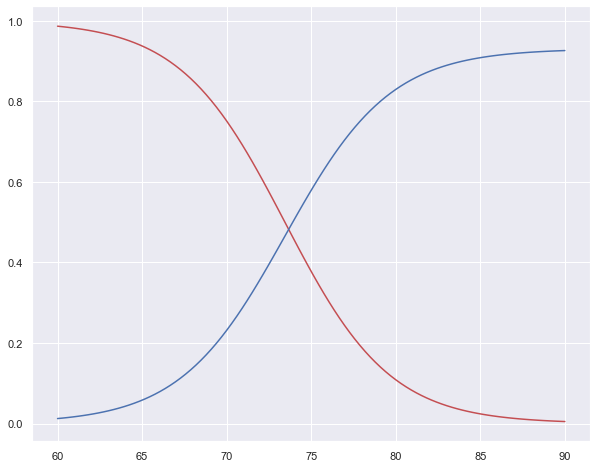

In [38]:
y1 = sum(y) / len(y)
y0 = 1 - y1
q0 = p0*y0 / (p0*y0 + p1*y1)
q1 = p1*y0 / (p0*y0 + p1*y1)

plt.figure(figsize=(10, 8))
plt.plot(xx, q0, 'r-')
plt.plot(xx, q1, 'b-');

The decision boundary is then at the location where these two probabilities cross. It is slightly to the right of where the distributions cross because of the correction due to the frequence of pitchers versus non-pitchers.

Note that the choice of decision boundary could be tuned if a particular problem (like one in medicine) required us to eliminate a particular type of error (false positives for example).

#### Using the Scikitlearn package

In [39]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [92]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

# Fixed for 1d

def plot_cat_model_1d(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    xx = np.arange(x_min, x_max, h)
    
    Z = clf.predict(np.c_[xx])

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.scatter(xx, Z, c=Z, cmap=cmap_light, marker='.');

    plt.scatter(X_train[:, 0], y_train, c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], y_test, c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Training Error: 0.6517533252720678
Testing Error: 0.6553398058252428


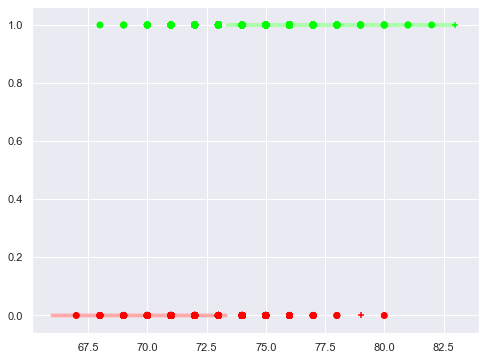

In [94]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train);
plot_cat_model_1d(clf, X_train, y_train, X_test, y_test)

### Higher Dimensional Versions

In higher dimensions we get linear boundaries, and with a generalization quadratic boundaries.

In [107]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 2, X_train[:, 1].max() + 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [108]:
X = np.array(major_2[['Height', 'Weight']])
y = np.array(major_2['Position'])

In [109]:
# We shuffle the data using a random permutation

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

Training Error: 0.6493349455864571
Testing Error: 0.6456310679611651


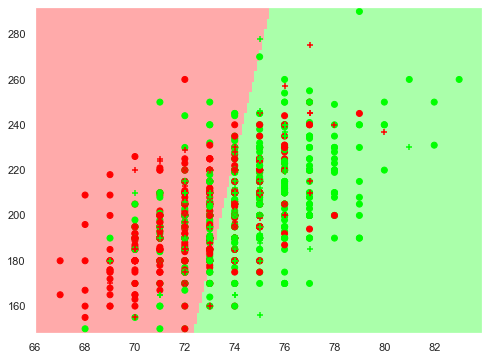

In [110]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train);
plot_cat_model(clf, X_train, y_train, X_test, y_test)

In [111]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Training Error: 0.6650544135429263
Testing Error: 0.6407766990291263


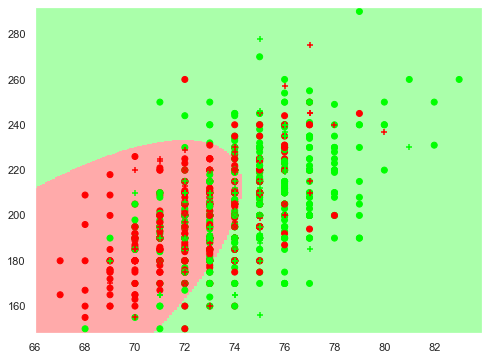

In [112]:
clf2 = QuadraticDiscriminantAnalysis()
clf2.fit(X_train, y_train)
plot_cat_model(clf2, X_train, y_train, X_test, y_test)

Comparing these methods to *Logistic Regression*

Training Error: 0.6481257557436517
Testing Error: 0.6456310679611651


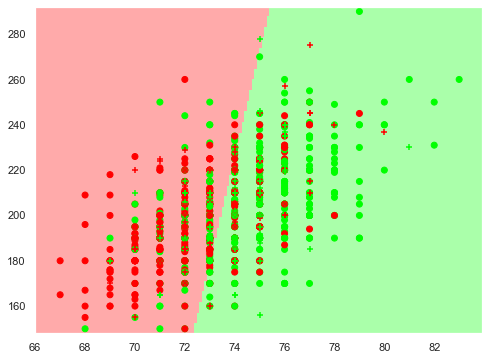

In [114]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver='lbfgs')
lg.fit(X_train, y_train)
plot_cat_model(lg, X_train, y_train, X_test, y_test)

## Support Vector Machines

Support vector machines work from a different principle, but one which is motivated by the linear decsion boundaries we are getting in the previous results using *Logistic Regression* and *Linear Discriminant Analysis*. To motivate them we start with a classification problem that is relatively rare: one where there is a clear separation in the training data.

In [120]:
iris = pa.read_csv('Data Sets/iris.csv')
iris.head()

,sepal length,sepal width,petal length,petal width,flower type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


The flower type 0 is significantly separated from flower types 1 and 0:

In [126]:
X = np.array(iris[['petal length', 'petal width']])
y = np.array(iris['flower type'].map({0:0, 1:1, 2:1}) )

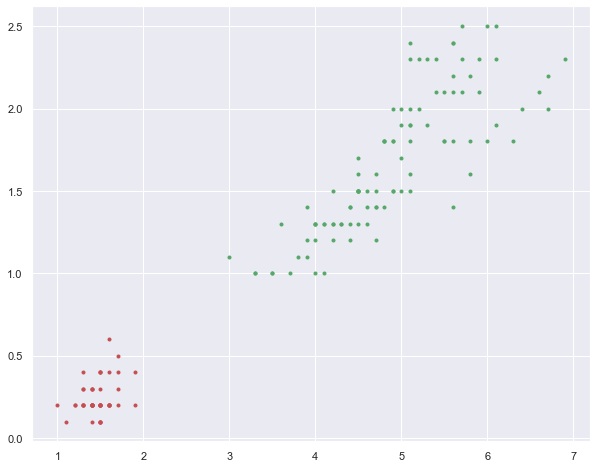

In [128]:
plt.figure(figsize=(10, 8))
plt.plot(X[y==0, 0], X[y==0, 1], 'r.')
plt.plot(X[y==1, 0], X[y==1, 1], 'g.');

In this case we see that there exists at least one (and hence infinitely many) lines that separate the two classes. 

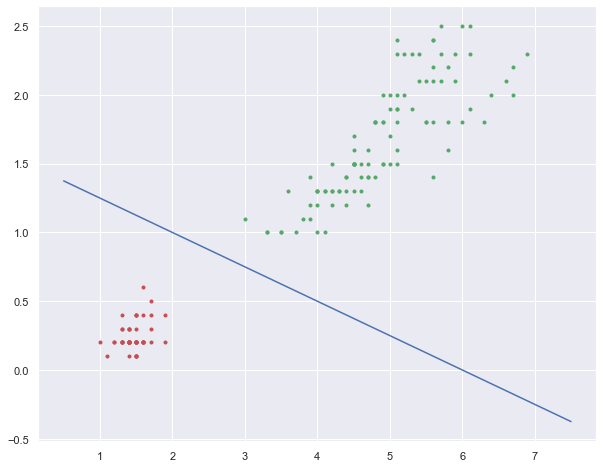

In [134]:
xx = np.linspace(0.5, 7.5, 50)
yy = 1.5 - 0.25*xx

plt.figure(figsize=(10, 8))
plt.plot(X[y==0, 0], X[y==0, 1], 'r.')
plt.plot(X[y==1, 0], X[y==1, 1], 'g.')
plt.plot(xx, yy, 'b-');

So the goal is to choose the best of all of the possible lines that separate the two classes. Of course, based on the whole class, you are not surprised and are expecting that there are many ideas one what we might mean by *best*.

One definition would be the dividing line that is as far as possible from both classes. We can define how far the line is from a class as the minimimum perpindicular distance from the points in that class.

The distance between the line and the closest training data is called the margin, and intuitively the larger the margin the better we expect the decision boundary to do on new data. Note then that the choice of decision boundary would only be affected by 